L'objectif de ce notebook est d'étudier le problème de classification avec le formalisme et la théorie étudiée dans l'article "On the Validation of Gibbs Algorithms: Training Datasets, Test Datasets and their Aggregation". Dans l'étude suivante, la fonction que l'on cherche à approximer est l'indicatrice d'une sous-partie de [1,m] où m est un entier naturel.

La cellule suivante crée deux datasets correspondant aux indicatrices des entiers impairs compris entre 1 et m, le premier dataset a un écart-type inférieur au second.

In [24]:
"""Dans cette partie, nous allons générer des bases de données aléatoires que nous utiliserons ultérieurement"""

import numpy as np
import random as rd

#paramètres

m = 10 #le cardinal de X 
Lambda = 1 #paramètre de régularisation
N = 100 #taille du dataset

#création des dataset

z1 = []      

for i in range(N):
    j = np.random.randint(1,m)
    if j%2 == 0:
        a = np.random.binomial(1,0.01)
        z1.append((j,a))
    else:
        a = np.random.binomial(1,0.99)
        z1.append((j,a))
        
z2 = []
for i in range(N):
    j = np.random.randint(1,m)
    if j%2 == 0:
        a = np.random.binomial(1,0.01)
        z2.append((j,a))
    else:
        a = np.random.binomial(1,0.99)
        z2.append((j,a))

z0 = z1 + z2 



On définit les fonctions nécessaires pour calculer le risque empirique.

In [25]:
"""L'objectif est de calculer les Expected Empirical Risks de différents GA sur le dataset aggrégé """


#on écrit une fonction qui calcule la liste des indicatrices de P([1,m])

def indicatrices(m): #fonction qui calcul récursivement la liste des indicatrices de P([1,m]) implémenter sous forme de liste de 0 et de 1 (m)
                        #il faut m > =1, la complexité est O(2^m)
        res = [[0],[1]]
        for i in range(m-1):
            l = []
            for ind in res:
                l.append([0]+ind)
                l.append([1]+ind)
            res = l
        return res
    
M = indicatrices(m)

#on défnit l'approximation de O de paramètre theta, on rappel que O est l'indicatrice d'une partie de 
#X et theta l'indicatrice d'une parti de X implémenté sous forme de vecteur de 0 et de 1 

def approximation(theta,x):   
    return theta[x]

#on définit la loss function

def loss_function(y1,y2):
    return (y1 == y2)

#on définit le risque empirique, la complexité est O(N)

def empirical_risk(theta,z):
    res = 0
    for elt in z:
        x = elt[0]
        y = elt[1] 
        if approximation(theta,x) != y:
            res += 1
    return (res/len(z))




Le problème ERM-RER peut être résolu par une méthode naïve qui consiste à calculer le risque empirique pour chaque indicatrice de [1,m]. C'est ce que nous faisons dans la cellule suivante.

In [26]:

"""Dans cette partie on souhaite résoudre le problème ERM, usuellement ce problème est difficile à résoudre, ici 
on utilise une méthode naïve qui a une complexité O(Nx2^m)"""

def solve_ERM(z):
    min = empirical_risk(M[0],z)
    theta_min = [M[0]]
    for theta in M:
        if empirical_risk(theta,z) == min:
            theta_min.append(theta)
        if empirical_risk(theta,z)<min:
            min = empirical_risk(theta,z)
            theta_min = [theta]
    return theta_min



L'article étudie une autre méthode, plutôt que de déterminer un vecteur de paramètre, on cherche la loi de probabilité de ce vecteur. Cette loi de probabilité est la solution du problème ERM-RER étudié dans l'article. 

In [27]:
""""Problème ERM-RER : ici on aborde la résolution  du problème avec régulation d'entropie relative"""

import numpy as np

#nous allons avoir besoin d'identifier les éléments de M à des objets hashable, ainsi on crée une bijection entre M et l'ensemble [1,2^m]

def indicatrice_to_int(theta):  #cette fonction renvoit la clé int d'une indicatrice, la complexité est O(m)
    res = 1
    for i in range(m):
        res += theta[i]*(2**(m-i-1))
    return res
      

#commençons par définir la fonction qui calcule l'entropie relative de deux mesures 

def entropy(P1,P2): #P1 et P2 sont des dictionnaires qui ont pour clés les singletons {theta} et pour valeur la mesure de ce singleton, la complexité est O(m2^m)
    res = 0
    for theta in M:
        key = indicatrice_to_int(theta)
        res += P1[key]*np.log(P1[key]/P2[key])
    return res

def uniform(): #cette fonction permet de créer le dictionnaire correspondant à la mesure uniforme sur M, la complexité est O(2^m)
    dico = {}
    for i in range(1,2**m +1):
        dico[i] = 1/(2^m)
    return dico

#calculons le risque empirique attendu (Expected Empirical Risk), cette fonction a pour complexité O(N2^m)

def expected_empirical_risk(P,z):
    res = 0
    for theta in M:
        ER = empirical_risk(theta,z)
        key = indicatrice_to_int(theta)
        res += ER * P[key] 
    res = res
    return res

#maintenant on écrit la fonction qui renvoit la solution du problème ERM-RER quand Q est la mesure uniforme sur M, la complexité est O((m+N)2^m)

def solve_ERM_RER(z,Lambda):
    dico = {}
    normalisation = 0
    for theta in M:
        normalisation += np.exp((-1)*(empirical_risk(theta,z)/Lambda))
    for theta in M:
        key = indicatrice_to_int(theta)
        dico[key] = (np.exp((-1)*(empirical_risk(theta,z)/Lambda)))/normalisation
    return dico





Nous allons visualiser la loi de probabilité en question, pour cela nous affichons la heatmap de la solution ERM-RER pour plusieurs valeurs de Lambda. On observe une concentration de la mesure autour de la solution ERM lorsque Lambda tend vers 0.

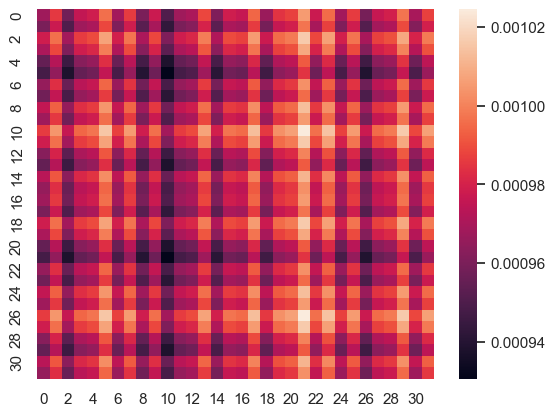

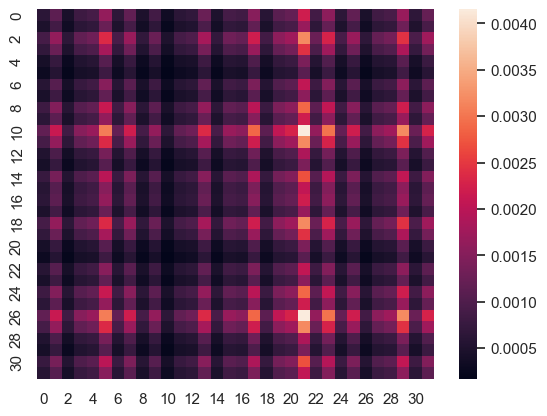

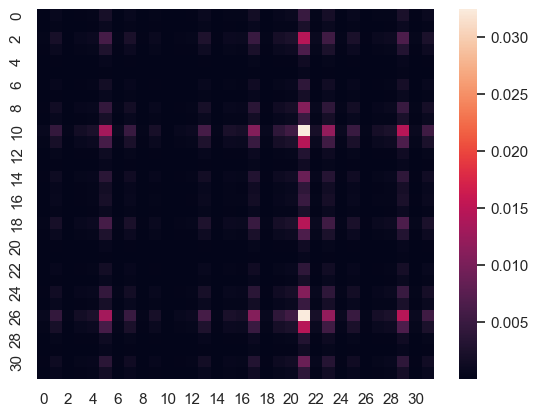

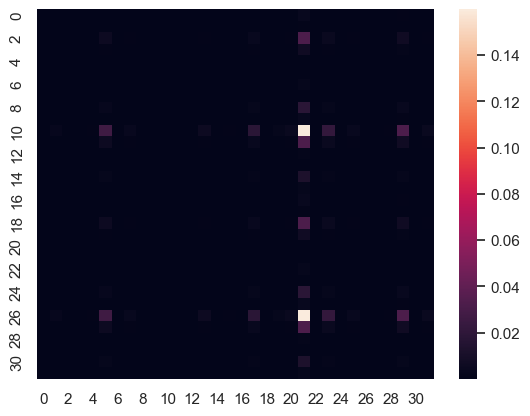

In [28]:
"""Visualisation de la solution du problème ERM-RER pour différentes 
valeurs de Lambda et comparaison avec la solution du problème ERM"""

import seaborn as sns
import matplotlib.pyplot as plt

def visualisation_ERM_RER(z,Lambda):
    dico = solve_ERM_RER(z,Lambda)

    matrix = np.zeros((2**(m//2),2**(m//2)))
    for i in range(2**(m//2)):
        for j in range(2**(m//2)):
            matrix[i][j] = dico[i*(2**(m//2))+j+1]
    sns.set()
    ax = sns.heatmap(matrix)
    plt.show()

for Lambda in [10,0.3,0.1,0.05]:
    visualisation_ERM_RER(z1,Lambda)
    """visualisation(z1,Lambda)
    visualisation(z2,Lambda)"""



La cellule suivante étudie la question de l'agrégat de datasets. Est-ce qu'il vaut mieux résoudre ERM-RER sur deux datasets séparemment et calculer la mesure moyenne des deux solutions ou alors résoudre ERM-RER sur le dataset fusionné ?

In [29]:
"""Dans cette partie nous allons évaluer différents risques empiriques en faisant varier les paramètres"""

#on introduit les GA des trois dataset

import time

#calcul chronométré de P1

start = time.time()

P1 = solve_ERM_RER(z1,Lambda)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution calcul de P1 : {elapsed:.2}ms')

#calcul chronométré de P2

start = time.time()

P2 = solve_ERM_RER(z2,Lambda)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution calcul de P2 : {elapsed:.2}ms')

#calcul chronométré de P0

start = time.time()

P0 = solve_ERM_RER(z0,Lambda)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution calcul de P0 : {elapsed:.2}ms')


def sum(P1,P2):
    dico = {}
    for key in P1.keys():
        dico[key] = P1[key] + P2[key]
    return dico

def scalar(P,alpha):
    dico = {}
    for key in P.keys():
        dico[key] = alpha * P[key]
    return dico

P3 = sum(scalar(P1,0.5),scalar(P2,0.5))


#calcul des EER sur leur dataset

R1 = expected_empirical_risk(P1,z1)
R2 = expected_empirical_risk(P2,z2)
R0 = expected_empirical_risk(P0,z0)

print("R0 : " + str(R0) +" R1 : " + str(R1) +" R2 : " +str(R2))

P = [P0,P1,P2,P3]
z = [z0,z1,z2]
res = np.zeros((4,3))
for i in range(len(P)):
    for j in range(len(z)):
        res[i][j] = expected_empirical_risk(P[i],z[j])
print(res)

#choisir le coefficient alpha qui définit P3 en fonction de la variance de z1 et z2?


Temps d'exécution calcul de P1 : 0.26ms
Temps d'exécution calcul de P2 : 0.26ms
Temps d'exécution calcul de P0 : 0.41ms
R0 : 0.10822943047397482 R1 : 0.12072303670591569 R2 : 0.09417217892472139
[[0.10822943 0.11681823 0.09964063]
 [0.11601534 0.12072304 0.11130765]
 [0.10585372 0.11753526 0.09417218]
 [0.11093453 0.11912915 0.10273991]]


Ici nous allons évaluer la loi de probabilité de la solution ERM-RER en l'une des solution ERM pour Lambda entre 0.001 et 0.1. On observe une convergence vers 0.5 car quand Lambda tend vers 0, la solution ERM-RER converge vers la loi uniforme sur l'ensemble des solutions de ERM.

[0.5, 0.5, 0.49999999999601685, 0.49999999681558677, 0.4999998222702109, 0.49999737766632124, 0.499981909995947, 0.4999224291301178, 0.49975784414600927, 0.49939501685655935, 0.49871540096494815, 0.49758699143817525, 0.4958776590856549, 0.49346704813179443, 0.49025559192925267, 0.48617023883312305, 0.4811670982459786, 0.47523151914734857, 0.46837621776798255, 0.4606380632784629, 0.45207406424861013, 0.4427570062012446, 0.43277109074245085, 0.4222078307218801, 0.41116237013342205, 0.39973032532961167, 0.3880051867142749, 0.3760762769983143, 0.3640272319684467, 0.35193495059508056, 0.33986895105123877, 0.327891065725062, 0.31605540967642193, 0.30440856158947777, 0.2929899027972768, 0.28183206739861577, 0.2709614641226895, 0.26039883792789414, 0.2501598460374819, 0.24025562904915812, 0.23069336284353908, 0.22147678126457285, 0.21260666300576547, 0.204081278887639, 0.19589679784509362, 0.1880476515510311, 0.18052685877417124, 0.17332631138603707, 0.16643702446689687, 0.159849353275224, 0.1

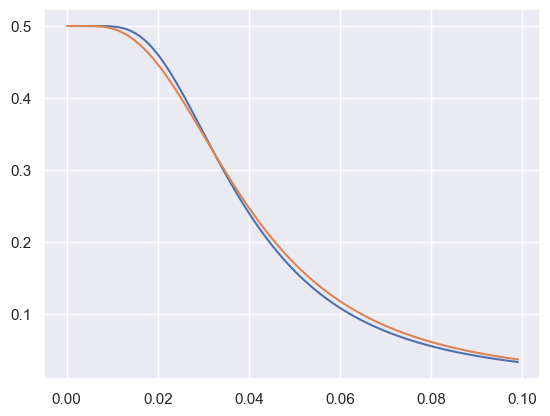

In [30]:
"""Ici on s'intéresse à la convergence d'un """



def visualisation_concentration_measure(z,L):    #L est la liste des lambda étudiés
    res = []
    theta0 = solve_ERM(z)[0]
    key = indicatrice_to_int(theta0)
    for Lambda in L:
        P0 = solve_ERM_RER(z,Lambda)
        res.append(P0[key])
    print(res)
    plt.plot(L,res)
    plt.show

L1 = [i/1000 for i in range(1,100)]
L2 = [i/10000 for i in range(1,100)]+[i/1000 for i in range(10,100)]

visualisation_concentration_measure(z1,L1)
visualisation_concentration_measure(z2,L2)

print(solve_ERM(z1))
print(solve_ERM(z2))



Etudions la convergence de EER quand Lambda tend vers 0, on observe que dans certains cas il converge vers une limite > 0 et dans un autre il tend vers 0.

[0.02, 0.02, 0.020000000000638334, 0.020000000511544536, 0.020000028647284944, 0.02000042446298185, 0.020002942426133735, 0.020012685112586158, 0.020039826884358534, 0.02010010022638259, 0.02021388851267676, 0.020404424869282713, 0.02069572892180723, 0.02111074566525776, 0.021669923066639004, 0.022390288456455763, 0.023284979607142126, 0.024363139957697406, 0.025630077420498852, 0.027087595334634375, 0.02873442109480488, 0.030566676345144685, 0.032578349216876336, 0.0347617426928218, 0.03710788363291004, 0.03960688461751766, 0.042248256062881906, 0.04502116955479889, 0.04791467549632812, 0.05091787935303151, 0.0540200813029024, 0.05721088418135931, 0.06048027441773089, 0.06381868030438678, 0.0672170115027138, 0.07066668322484705, 0.07415962807039475, 0.07768829806397211, 0.08124565904338903, 0.08482517919487761, 0.0884208132217245, 0.0920269833645507, 0.09563855826229835, 0.09925083044893013, 0.1028594931180482, 0.10646061665201452, 0.11005062530007662, 0.11362627429798314, 0.117184627

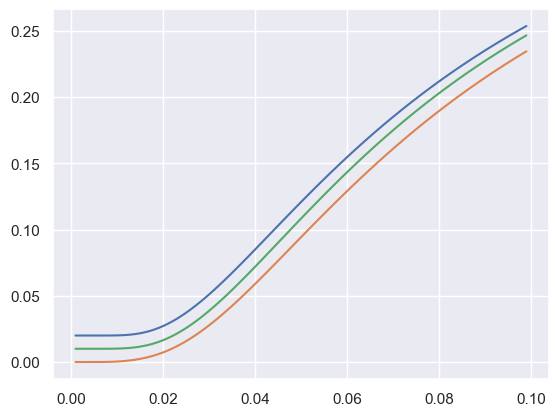

In [31]:
"""étude de EER quand lambda diminue"""


def visualisation_EER(z,L):
    res = []
    for Lambda in L:
        P = solve_ERM_RER(z,Lambda)
        EER = expected_empirical_risk(P,z)
        res.append(EER)
    plt.plot(L,res)
    print(res)
    plt.show

L1 = [i/1000 for i in range(1,100)]

visualisation_EER(z1,L1)
visualisation_EER(z2,L1)
visualisation_EER(z0,L1)

'''on souhaite calculer delta étoile qui est l'inf de Rz(P*)'''

def delta_star(z):
    return min([empirical_risk(theta,z) for theta in M])

print("delta star 1 :" + str(delta_star(z1))+ "/    delta star 2 :" + str(delta_star(z2)) +"/    delta star 0 :" + str(delta_star(z0)))